# Takes raw background catalogue and fixes columns, produces CMDs and writes data to good_bgd_data.csv

In [1]:
# Call the relevant python packages
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import glob, os
import nway
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Rename horrible column names

In [7]:
# Make sure the N/A flag is 9999 in the below file
file = 'background/background_good_mean_fits.csv'
data = ascii.read(file, data_start=1)
print(data.colnames)

# A list of all the current column names we want to change and include in the final table
old_cols=['S1_0_ID','S1_0_RA','S1_0_DEC','S1_0_MAG1_0','S1_0_ERR1_0',
          'S2_0_ID','S2_0_RA','S2_0_DEC','S2_0_MAG2_0','S2_0_ERR2_0']

# A list of all the new column names we want, corresponding to the list above
new_cols=['ID_36_0','RA_36_0','Dec_36_0','mag_36_0','mag_err_36_0',
          'ID_45_0','RA_45_0','Dec_45_0','mag_45_0','mag_err_45_0']

# Rename each column
for i in range(len(old_cols)):
    old_column = old_cols[i]
    new_column = new_cols[i]
    data.rename_column(old_column,new_column)

# Order columns in a sensible order
all_cols=['ID','RA','DEC',
          'ID_36_0','RA_36_0','Dec_36_0','mag_36_0','mag_err_36_0',
          'ID_45_0','RA_45_0','Dec_45_0','mag_45_0','mag_err_45_0']

new_data = data[all_cols]

ascii.write(new_data, 'final_cats/bgd_cat_columns.csv',format='csv')

['S1_0_ID', 'S1_0_RA', 'S1_0_DEC', 'S1_0_MAG1_0', 'S1_0_ERR1_0', 'S2_0_ID', 'S2_0_RA', 'S2_0_DEC', 'S2_0_MAG2_0', 'S2_0_ERR2_0', 'Separation_S2_0_S1_0', 'Separation_max', 'ncat', 'dist_bayesfactor', 'dist_post', 'p_single', 'p_any', 'p_i', 'match_flag', 'RA', 'DEC', 'ID']


# Read in new csv with sensible column names

In [8]:
# Import data
second_file = 'final_cats/bgd_cat_columns.csv'
second_data = ascii.read(second_file, data_start=1)

# Find bad magnitude errors for both filters

(20.5, 13.5)

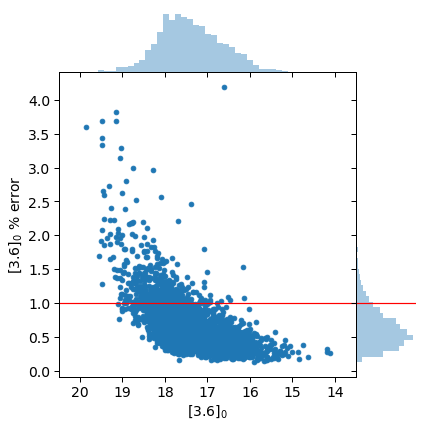

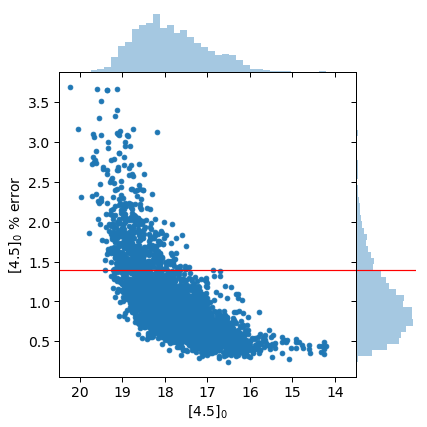

In [26]:
# Consider spread of magnitude errors
# NB: the factor of 2 in the percentage represents that the mag errors have not yet been multiplied by 2!

good_36_0_idx = np.where((second_data['mag_36_0']!=-99))
# Setting up figure
plt.rc('font', family='sans-serif')
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=11)
bbb = sns.jointplot(second_data['mag_36_0'][good_36_0_idx],2*100*second_data['mag_err_36_0'][good_36_0_idx]/second_data['mag_36_0'][good_36_0_idx], kind="scatter",
                   space=0)
bbb.set_axis_labels("[3.6]$_0$","[3.6]$_0$ % error")
bbb.ax_joint.axhline(y=1,color='red')
plt.axhline(y=1,color='red')
bbb.ax_marg_x.set_xlim(20.5,13.5)
#bbb.ax_marg_y.set_ylim(0,3.5)

good_45_0_idx = np.where((second_data['mag_45_0']!=-99))
# Setting up figure
plt.rc('font', family='sans-serif')
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=11)
bbb = sns.jointplot(second_data['mag_45_0'][good_45_0_idx],2*100*second_data['mag_err_45_0'][good_45_0_idx]/second_data['mag_45_0'][good_45_0_idx], kind="scatter",
                   space=0)
bbb.set_axis_labels("[4.5]$_0$","[4.5]$_0$ % error")
bbb.ax_joint.axhline(y=1.4,color='red')
plt.axhline(y=1.4,color='red')
bbb.ax_marg_x.set_xlim(20.5,13.5)
#bbb.ax_marg_y.set_ylim(0,3.5)

In [51]:
# Find how much data would be left if you culled sources above the red line
good_mag_error_36_0_idx = np.where((2*100*second_data['mag_err_36_0']/second_data['mag_36_0'])<=1)
print("% left after culling these (36_0): ",100*len(good_mag_error_36_0_idx[0])/len(second_data[good_36_0_idx]))

good_mag_error_45_0_idx = np.where((2*100*second_data['mag_err_45_0']/second_data['mag_45_0'])<=1.4)
print("% left after culling these (45_0): ",100*len(good_mag_error_45_0_idx[0])/len(second_data[good_45_0_idx]))

print("These average percentages should be almost equal to ensure no bias between filters")

% left after culling these (36_0):  86.45392380332139
% left after culling these (45_0):  82.05796157603386
These average percentages should be almost equal to ensure no bias between filters


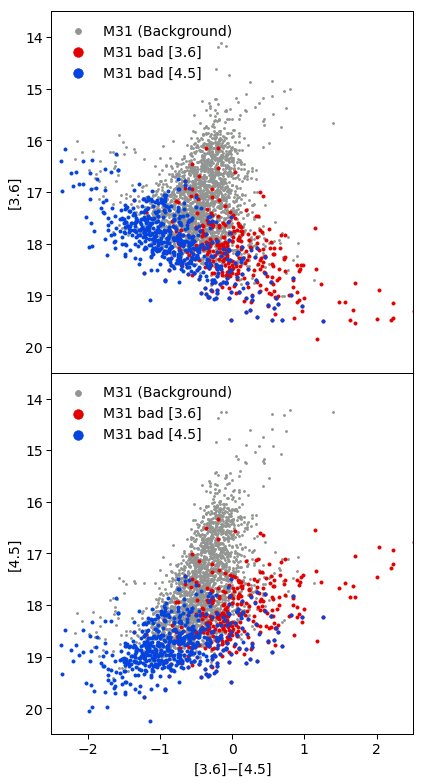

In [52]:
# Make CMDs

# NB: need to multiply errors by two here as this hasn't yetbeen done for the background!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Note that when using E0 there is no need to find !=-99 points as all E0 are valid
good_bgd_mag = np.where((second_data['mag_36_0']!=-99)&(second_data['mag_45_0']!=-99))
bad_mag_error_idx_36 = np.where((2*100*data['mag_err_36_0']/data['mag_36_0'])>1)
bad_mag_error_idx_45 = np.where((2*100*data['mag_err_45_0']/data['mag_45_0'])>1.4)

plt.rc('font', family='sans-serif')
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=14)
# plt.rcdefaults()
# Setting up figure
#ax = plt.gca()
plt.figure(figsize=(6,11))

plt.subplot(2,1,1)
# Plot all sensible stars which satify the cut criteria
plt.scatter(second_data['mag_36_0'][good_bgd_mag]-second_data['mag_45_0'][good_bgd_mag], second_data['mag_36_0'][good_bgd_mag], s=3.9,color=sns.xkcd_rgb['grey'], label="M31 (Background)")
plt.scatter(second_data['mag_36_0'][bad_mag_error_idx_36]-second_data['mag_45_0'][bad_mag_error_idx_36], second_data['mag_36_0'][bad_mag_error_idx_36], s=10,color=sns.xkcd_rgb['red'], label="M31 bad [3.6]")
plt.scatter(second_data['mag_36_0'][bad_mag_error_idx_45]-second_data['mag_45_0'][bad_mag_error_idx_45], second_data['mag_36_0'][bad_mag_error_idx_45], s=10,color=sns.xkcd_rgb['blue'], label="M31 bad [4.5]")
plt.ylabel("[3.6]", fontsize=14)
plt.xlim(-2.5,2.5)
plt.ylim(20.5,13.5)
# Add a legend
plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)

plt.subplot(2,1,2)
# Plot all sensible stars which satify the cut criteria
plt.scatter(second_data['mag_36_0'][good_bgd_mag]-second_data['mag_45_0'][good_bgd_mag], second_data['mag_45_0'][good_bgd_mag], s=3.9,color=sns.xkcd_rgb['grey'], label="M31 (Background)")
plt.scatter(second_data['mag_36_0'][bad_mag_error_idx_36]-second_data['mag_45_0'][bad_mag_error_idx_36], second_data['mag_45_0'][bad_mag_error_idx_36], s=10,color=sns.xkcd_rgb['red'], label="M31 bad [3.6]")
plt.scatter(second_data['mag_36_0'][bad_mag_error_idx_45]-second_data['mag_45_0'][bad_mag_error_idx_45], second_data['mag_45_0'][bad_mag_error_idx_45], s=10,color=sns.xkcd_rgb['blue'], label="M31 bad [4.5]")
plt.xlabel("[3.6]$-$[4.5]", fontsize=14)
plt.ylabel("[4.5]", fontsize=14)
plt.xlim(-2.5,2.5)
plt.ylim(20.5,13.5)
# Add a legend
plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()
plt.close()

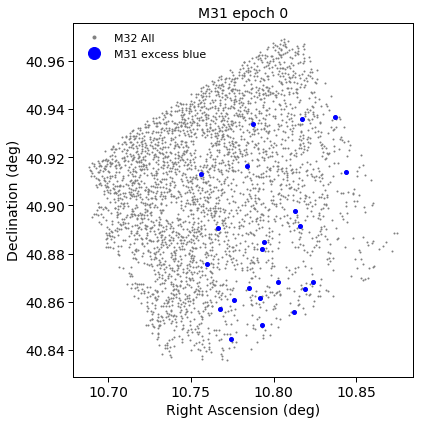

In [59]:
# Plot sources with a high or low colour that aren't bad mag error too.
# These graphs apply to both [3.6] and [4.5].
blue_1_idx = np.where((second_data['mag_36_0']-second_data['mag_45_0'] < -1.6) &(second_data['mag_36_0']!=-99)&(second_data['mag_45_0']!=-99)&
                     ((2*100*second_data['mag_err_36_0']/second_data['mag_36_0'])<=1) &
                      ((2*100*second_data['mag_err_45_0']/second_data['mag_45_0'])<=1.4))

# Setting up figure
plt.rc('font', family='sans-serif')
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=11)
plt.figure(figsize=(6,6))
ax = plt.gca()                        # Sets up active plot region

# Make the actual plot
plt.plot(second_data['RA'], second_data['DEC'], '.', color='grey', ms=2, label="M32 All")
plt.plot(second_data['RA'][blue_1_idx], second_data['DEC'][blue_1_idx], 'o', color='blue', ms=4, label="M31 excess blue ")    
plt.xlabel('Right Ascension (deg)', size=14)
plt.ylabel('Declination (deg)', size=14)
plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
plt.title('M31 epoch 0',fontsize=14)

#plt.savefig("blah.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

# Now reduce catalogue based upon mag errors above and edge effects

In [67]:
# Read in data again to make sure changes happen only once
second_file = 'final_cats/bgd_cat_columns.csv'
second_data = ascii.read(second_file, data_start=1)

# Multiply magnitude errors by 2
#NB: if error is already -99 then it will be left alone
for i in range(len(second_data)):
    if second_data['mag_err_36_0'][i]!=-99:
        second_data['mag_err_36_0'][i]=second_data['mag_err_36_0'][i]*2
    if second_data['mag_err_45_0'][i]!=-99:
        second_data['mag_err_45_0'][i]=second_data['mag_err_45_0'][i]*2

#################################################################################################################
# Find where mag errors are large and set all their properties to -99
print("Number of initial sources: ",len(second_data))
# Find where sources are not bad data (-99) but have a large mag error

print("Initial numbers on bad mag errors:")
bad_36_0_idx=np.where((second_data['mag_36_0']!=-99)&((100*second_data['mag_err_36_0']/second_data['mag_36_0'])>1))
print("Now number of bad mag data for 36_0 is ",len(bad_36_0_idx[0]))
bad_45_0_idx=np.where((second_data['mag_45_0']!=-99)&((100*second_data['mag_err_45_0']/second_data['mag_45_0'])>1.4))
print("Now number of bad mag data for 45_0 is ",len(bad_45_0_idx[0]))

for i in range(len(second_data)):
    if ((second_data['mag_36_0'][i]!=-99)&((100*second_data['mag_err_36_0'][i]/second_data['mag_36_0'][i])>1)):
        second_data['ID_36_0'][i]=-99
        second_data['RA_36_0'][i]=-99
        second_data['Dec_36_0'][i]=-99
        second_data['mag_36_0'][i]=-99
        second_data['mag_err_36_0'][i]=-99

    if ((second_data['mag_45_0'][i]!=-99)&((100*second_data['mag_err_45_0'][i]/second_data['mag_45_0'][i])>1.4)):
        second_data['ID_45_0'][i]=-99
        second_data['RA_45_0'][i]=-99
        second_data['Dec_45_0'][i]=-99
        second_data['mag_45_0'][i]=-99
        second_data['mag_err_45_0'][i]=-99


print("Final numbers on bad mag errors:")
bad_36_0_idx=np.where((second_data['mag_36_0']!=-99)&((100*second_data['mag_err_36_0']/second_data['mag_36_0'])>1))
print("Now number of bad mag data for 36_0 is ",len(bad_36_0_idx[0]))
bad_45_0_idx=np.where((second_data['mag_45_0']!=-99)&((100*second_data['mag_err_45_0']/second_data['mag_45_0'])>1.4))
print("Now number of bad mag data for 45_0 is ",len(bad_45_0_idx[0]))

#################################################################################################################

# Now cull sources with a colour less than -1.6 in each epoch as these are edge affected sources.
# Make sure already only sources with good data are included in this because:
# If only one of the sources is bad then it won't show up on the CMD anyway and;
# If both sources are bad then we can ignore it anyway

#print("Initial numbers of edge affected sources in each epoch:")
#edge_E1_idx=np.where(((second_data['mag_36_0']-second_data['mag_45_0'])<-1.6) &
#                     (second_data['mag_36_0']!=-99) & (second_data['mag_45_0']!=-99))
#print("The number of E0 edge affected sources (check on CMD above)",len(edge_E0_idx[0]))


#for i in range(len(second_data)):
#    if (((second_data['mag_36_0'][i]-second_data['mag_45_0'][i])<-1.6) &
#        (second_data['mag_36_0'][i]!=-99) & (second_data['mag_45_0'][i]!=-99)):
#        second_data['ID_36_0'][i]=-99
#        second_data['RA_36_0'][i]=-99
#        second_data['Dec_36_0'][i]=-99
#        second_data['mag_36_0'][i]=-99
#        second_data['mag_err_36_0'][i]=-99
#        second_data['ID_45_0'][i]=-99
#        second_data['RA_45_0'][i]=-99
#        second_data['Dec_45_0'][i]=-99
#        second_data['mag_45_0'][i]=-99
#        second_data['mag_err_45_0'][i]=-99

        
#print("Final numbers of edge affected sources in each epoch:")
#edge_E0_idx=np.where(((second_data['mag_36_0']-second_data['mag_45_0'])<-1.6) &
#                     (second_data['mag_36_0']!=-99) & (second_data['mag_45_0']!=-99))
#print("The number of E0 edge affected sources (check on CMD above)",len(edge_E0_idx[0]))

###################################################################################################################

# Now recalculate meanRA_lambda, meanDec_lambda, 36/45 associations
    
#second_data[0:3].show_in_notebook()

# Use this line to check to see if any show up as having < 2 of each of the filter associations
oh_dear_idx = np.where((second_data['mag_36_0']==-99)|(second_data['mag_45_0']==-99))
print("Those with only one filter of data",len(oh_dear_idx[0]))

# Now cull those with asn_lambda < 2
second_data['good_source?']=1
for i in range(len(second_data)):
    if ((second_data['mag_36_0'][i]==-99)|(second_data['mag_45_0'][i]==-99)):
        second_data['good_source?'][i]=0
good_source_idx = np.where(second_data['good_source?']==1)
good_data=second_data[good_source_idx]
print("Number of good sources: ",len(good_data))


# Then find total_asn & mean coordinates and do histogram
for i in range(len(good_data)):
    good_data['RA'][i] = (good_data['RA_36_0'][i]+good_data['RA_45_0'][i])/2
    good_data['DEC'][i] = (good_data['Dec_36_0'][i]+good_data['Dec_45_0'][i])/2
    

good_data[0:3].show_in_notebook()
ascii.write(good_data,'good_bgd_data.csv',format='csv')

Number of initial sources:  3071
Initial numbers on bad mag errors:
Now number of bad mag data for 36_0 is  416
Now number of bad mag data for 45_0 is  551
Final numbers on bad mag errors:
Now number of bad mag data for 36_0 is  0
Now number of bad mag data for 45_0 is  0
Those with only one filter of data 829
Number of good sources:  2242


# Read in good_bgd_data.csv

In [2]:
# Read in the file with the good data
file = 'good_bgd_data.csv'
data = ascii.read(file, data_start=1)
print(np.max(data['mag_36_0']))
print(np.max(data['mag_45_0']))

19.01750491
19.41855224


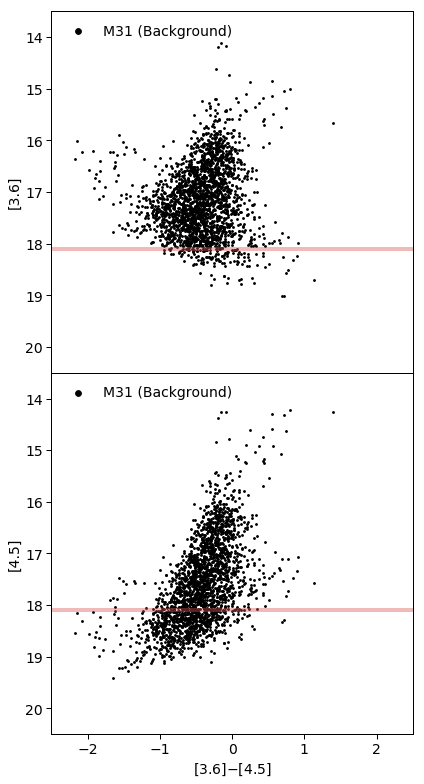

In [70]:
# CMDs
plt.rc('font', family='sans-serif')
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("legend", fontsize=14)
plt.figure(figsize=(6,11))

plt.subplot(2,1,1)
# Plot all sensible stars
plt.scatter(data['mag_36_0']-data['mag_45_0'], data['mag_36_0'], s=3.9,color=sns.xkcd_rgb['black'], label="M31 (Background)")
# Overplot variable sources
#plt.scatter(data['mag_36_0'][bad_mag_error_idx_36_0a]-data['mag_45_0'][bad_mag_error_idx_36_0a], data['mag_36_0'][bad_mag_error_idx_36_0a],s=19,color=sns.xkcd_rgb['blue'],label="bad [3.6] error")
#plt.scatter(data['mag_36_0'][bad_mag_error_idx_45_0a]-data['mag_45_0'][bad_mag_error_idx_45_0a], data['mag_36_0'][bad_mag_error_idx_45_0a],s=19,color=sns.xkcd_rgb['red'],label="bad [4.5] error")
#plt.xlabel("[3.6]$-$[4.5]", fontsize=14)
plt.ylabel("[3.6]", fontsize=14)
plt.xlim(-2.5,2.5)
plt.ylim(20.5,13.5)
#Add TRGB
plt.axhline(y=-6.3+24.4, color=sns.xkcd_rgb["pale red"], linestyle='-', alpha=0.4, linewidth=4)
#plt.axvline(x=1.5)
#plt.axvline(x=-1.6)
plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
#plt.title('M32 E1', fontsize=18)
#plt.savefig("bla.pdf", bbox_inches='tight')    # Saves the figure is uncommented
#plt.tight_layout()
#plt.show()
#plt.close()


# Repeat for 4.5 on the y-axis
plt.subplot(2,1,2)
plt.scatter(data['mag_36_0']-data['mag_45_0'], data['mag_45_0'], s=3.9,color=sns.xkcd_rgb['black'], label="M31 (Background)")
# Overplot variable sources
#plt.scatter(data['mag_36_0'][bad_mag_error_idx_36_0a]-data['mag_45_0'][bad_mag_error_idx_36_0a], data['mag_45_0'][bad_mag_error_idx_36_0a],s=19,color=sns.xkcd_rgb['blue'],label="bad [3.6] error")
#plt.scatter(data['mag_36_0'][bad_mag_error_idx_45_0a]-data['mag_45_0'][bad_mag_error_idx_45_0a], data['mag_45_0'][bad_mag_error_idx_45_0a],s=19,color=sns.xkcd_rgb['red'],label="bad [4.5] error")
plt.xlabel("[3.6]$-$[4.5]", fontsize=14)
plt.ylabel("[4.5]", fontsize=14)
plt.xlim(-2.5,2.5)
plt.ylim(20.5,13.5)
#plt.axvline(x=1.5)
#plt.axvline(x=-1.6)
#Add TRGB
plt.axhline(y=-6.3+24.4, color=sns.xkcd_rgb["pale red"], linestyle='-', alpha=0.4, linewidth=4)
plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
#plt.title('M32 E1', fontsize=18)
#plt.savefig("bla.pdf", bbox_inches='tight')    # Saves the figure is uncommented
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()
plt.close()

In [55]:
from scipy.stats import binned_statistic as binstat
bins_mag=np.arange(14,20.5,0.5)

bin_counts_45_0, bin_edges_45_0, binnumber_45_0 = binstat(data['mag_45_0'],values=None,statistic='count',bins=bins_mag)
print(bin_counts_45_0)

# x relates to the rows
# y relates to the columns

[  7.   9.  16.  39. 175. 271. 413. 503. 537. 247.  25.   0.]


In [46]:
for i in range(3):
    print(data['mag_45_0'][i])

17.52255224
17.56455224
16.81055224


In [31]:
bin_idx=np.where((data['mag_36_0']-data['mag_45_0']<0)&(data['mag_36_0']-data['mag_45_0']>=-1)&
                 (data['mag_45_0']<18)&(data['mag_45_0']>=17))
print(len(bin_idx[0]))

801
